In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.sparse.linalg import svds
from sklearn.utils.extmath import svd_flip
import pcshrink

In [2]:
data = pcshrink.UnpackedAncestryMap("data/patterson_example/forjn/yfhx")
norm = pcshrink.Normalizer(data.Y, .05, "patterson")

In [3]:
def svd(Y, k):
    
    U, S, VT = svds(Y, k)

    # singular values
    S = np.diag(S[::-1])

    U, VT = svd_flip(U[:, ::-1], VT[::-1])

    V = VT.T
    
    return(U, S, V)

def orient_sign(U, U_ref):
    """
    """
    p, k = U.shape
    D = np.zeros((k, k))
    for i in range(k):
        D[i, i] = np.sign(np.corrcoef(U[:, i], U_ref[:, i])[0, 1])
    
    U = U @ D
    
    return(U)

In [154]:
Y = norm.Y
p, n = Y.shape
k = 20
U, S, V = svd(Y, k)
V = ((U @ S).T @ Y).T
V /= np.linalg.norm(V, axis=0)

V.shape

(60, 20)

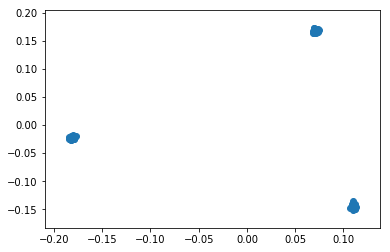

In [155]:
plt.scatter(V[:, 0], V[:, 1])

In [225]:
n_pop = 50000 # number of sample indiviudals to simulatie
U_pop = U
S_pop = S
V_pop = V[np.random.randint(0, n, n_train + n_test), :] + np.random.normal(0, 0.01, size=(n_train + n_test, k))

n_train = 100
n_test = 100

V_samp = V_pop[np.random.randint(0, n, n_train + n_test), :] 
Y_samp = U @ S @ V_samp.T

#n_test = 50 # number of projected individuals to simulation 
# genotypes of both training and test individuals
#Y_sim = np.empty((p, n_train + n_test)) 
# sampling variance for genotypes
#sigma2_train = 1
# "simulate" population positions by random sampling the original + noise
# simulation genotypes
#Y_sim = (U @ S @ V_true.T) + np.random.normal(0, sigma2_train, (p, n_train + n_test))

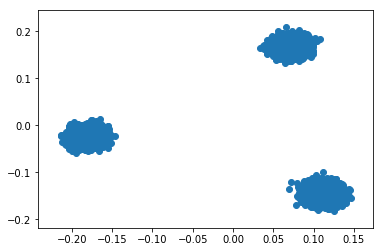

In [235]:
plt.scatter(V_true[:,0], V_true[:, 1])

In [236]:
# split into test and train
Y_train = Y_samp[:, :n_train]
Y_test = Y_samp[:, n_train:]

In [237]:
%%time
r = 2
U_train, S_train, V_train = svd(Y_train, r)
V_train = V_train / np.linalg.norm(V_train, axis=0)

#V_train = ((U @ S).T @ Y_train).T

# normalize to unit variance for each column
#V_train = V_train / np.linalg.norm(V_train, axis=0)

CPU times: user 1min 14s, sys: 4.58 s, total: 1min 19s
Wall time: 2.91 s


In [238]:
# project onto training pcs 
#V_test = ((U @ S).T @ Y_test).T
V_test = ((U_train @ S_train).T @ Y_test).T

# normalize to unit variance for each column
V_test = V_test / np.linalg.norm(V_test, axis=0)
#np.linalg.norm(V_test, axis=0)

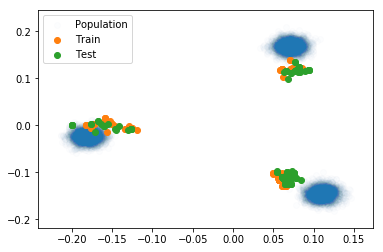

In [241]:
plt.scatter(V_true[:, 0], V_true[:, 1], label="Population", alpha=.01)
plt.scatter(V_train[:, 0], V_train[:, 1], label="Train")
plt.scatter(V_test[:, 0], V_test[:, 1], label="Test")
plt.legend()

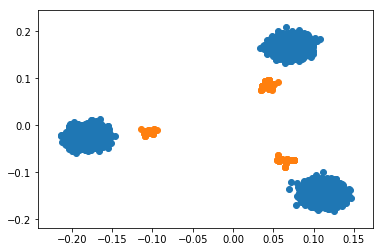

In [243]:
V_sim = ((U @ S).T @ Y_samp).T
V_sim /= np.linalg.norm(V_sim, axis=0)
plt.scatter(V_true[:, 0], V_true[:, 1], label="Population")
plt.scatter(V_sim[:, 0], V_sim[:, 1], label="Population")

---

In [ ]:
k = 50
n_train = 100
n_test = 100
n = n_train + n_test
p = 50000
L = np.random.normal(size=(n, k))
F = np.random.normal(size=(p, k))
M = (L @ F.T).T

U, S, V = svd(M, k)
M = U @ S @ V.T
Y = M + np.random.normal(0, 1, size=(p, n))

Y_train = Y[:, :n_train]
Y_test = Y[:, :n_test]

In [ ]:
U_train, S_train, V_train = svd(Y_train, 2)
V_train /= np.linalg.norm(V_train, axis=0)

In [ ]:
V_test = ((U_train @ S_train).T @ Y_test).T
V_test /= np.linalg.norm(V_test, axis=0)

In [ ]:
plt.scatter(V[:, 0], V[:, 1], color="black")
plt.scatter(V_train[:, 0], V_train[:, 1], )
plt.scatter(V_test[:, 0], V_test[:, 1])